In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [227]:
velha = pd.read_csv('amostras_.csv',sep=';')

In [228]:
X = velha.drop(columns=['classe'])
y = velha['classe'].values


In [229]:
treino_X, teste_X, treino_y, teste_y = tts(X, y, random_state=42,test_size=0.1, stratify=y)
tr_X, v_X, tr_y, v_y = tts(treino_X, treino_y, random_state=42,test_size=0.1, stratify=treino_y)
print(v_X.shape)
print(teste_X.shape)


(68, 9)
(75, 9)


Validacao Cruzada com GridSearchCV

In [230]:
param_grid = {'n_neighbors': range(2, 20)}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=10,         # 10-fold cross-validation
    scoring='accuracy'
)
grid.fit(tr_X, tr_y)
print("Melhor k:", grid.best_params_)

Melhor k: {'n_neighbors': 13}


Scores de validação cruzada: [0.78688525 0.81967213 0.70491803 0.6557377  0.70491803 0.72131148
 0.68852459 0.71666667 0.75       0.63333333]
Média: 0.7182 (+/- 0.1065)


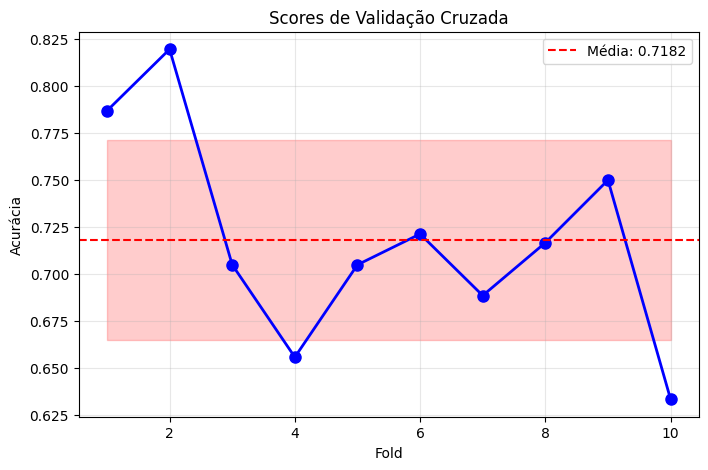

In [231]:
cv_scores = cross_val_score(grid.best_estimator_, tr_X, tr_y.ravel(), cv=10, scoring='accuracy')
print(f"Scores de validação cruzada: {cv_scores}")
print(f"Média: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualização dos scores de validação cruzada
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), cv_scores, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Média: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 11), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='red')
plt.xlabel('Fold')
plt.ylabel('Acurácia')
plt.title('Scores de Validação Cruzada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Matriz de confusao (Cruzada)

In [232]:
clf = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
clf.fit(tr_X, tr_y)
y_pred_cru = clf.predict(v_X)  # usa DataFrame com nomes de features
cm = confusion_matrix(v_y, y_pred_cru)

Validacao Explicita (10%)

In [233]:
melhor_k = None
melhor_acc = 0 
k_values = []
accuracies=[]
for k in range(2, 20):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(tr_X, tr_y)
    acc = clf.score(v_X,v_y)
    k_values.append(k)
    accuracies.append(acc)

    if acc > melhor_acc:
        melhor_acc = acc
        melhor_k = k

acc_expl = melhor_acc
print(f'Melhor acuracia: {melhor_acc}')
print("Melhor k encontrado:", melhor_k)

Melhor acuracia: 0.7205882352941176
Melhor k encontrado: 11


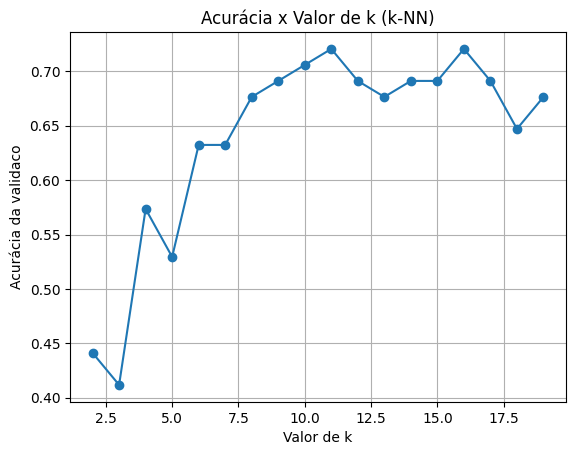

In [234]:
plt.plot(k_values, accuracies, marker="o")
plt.xlabel("Valor de k")
plt.ylabel("Acurácia da validaco")
plt.title("Acurácia x Valor de k (k-NN)")
plt.grid(True)
plt.show()

Matriz de Confusao da validacao explicita

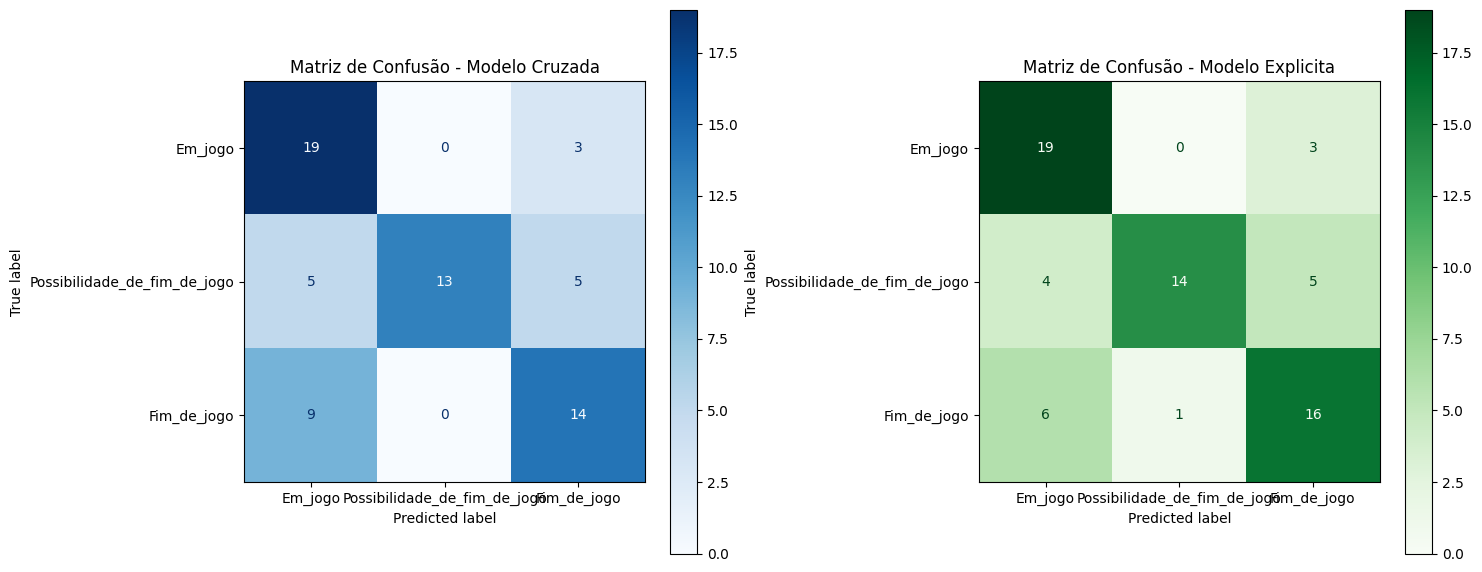

Relatório de Classificação - Modelo Cruzado:
                              precision    recall  f1-score   support

                     Em_jogo       0.58      0.86      0.69        22
Possibilidade_de_fim_de_jogo       1.00      0.57      0.72        23
                 Fim_de_jogo       0.64      0.61      0.62        23

                    accuracy                           0.68        68
                   macro avg       0.74      0.68      0.68        68
                weighted avg       0.74      0.68      0.68        68



In [235]:
clf = KNeighborsClassifier(n_neighbors=melhor_k)
clf.fit(tr_X, tr_y)
y_pred_expl = clf.predict(v_X)  # usa DataFrame com nomes de features

# Matriz de confusão do modelo otimizado
cm_expl = confusion_matrix(v_y, y_pred_expl)

# Comparação das matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz original
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriz de Confusão - Modelo Cruzada')

# Matriz otimizada
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_expl, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Matriz de Confusão - Modelo Explicita')

plt.tight_layout()
plt.show()

# Relatório de classificação do modelo otimizado
print("Relatório de Classificação - Modelo Cruzado:")
print(classification_report(v_y, y_pred_cru, target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))


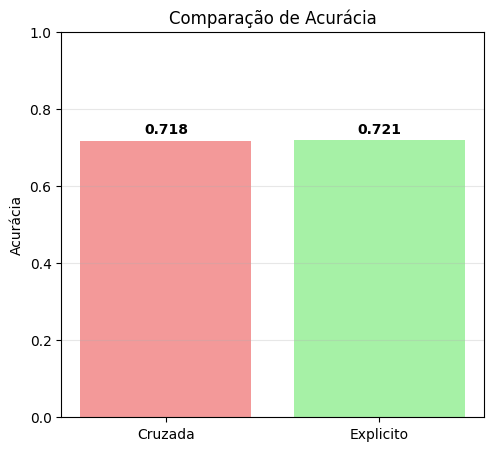

In [236]:
# Visualização da comparação de performance
plt.figure(figsize=(12, 5))

# Gráfico 1: Comparação de acurácias
plt.subplot(1, 2, 1)
models = ['Cruzada', 'Explicito']
accuracies = [grid.best_score_, acc_expl]
colors = ['lightcoral', 'lightgreen']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.title('Comparação de Acurácia')
plt.ylabel('Acurácia')
plt.ylim(0, 1)

# Adicionar valores nas barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

SCORE DO TESTE COM K VIA VALIDACAO EXPLICITA

In [237]:
clf = neighbors.KNeighborsClassifier(n_neighbors=melhor_k)
clf.fit(tr_X, tr_y)
accs = clf.score(teste_X, teste_y)
print("Acuracia: ", accs)

Acuracia:  0.7333333333333333


SCORE DO TESTE COM K VIA VALIDACAO CRUZADA

In [238]:
accs = grid.score(teste_X,teste_y)
print("Acuracia: ", accs)

Acuracia:  0.76


TESTES

In [239]:
k_values = []
accuracies = []
maior = -1.0
melhor_k = None
melhor_pred = None

for k in range(2, 20):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(tr_X, tr_y)                 # DataFrame/Series
    acc = clf.score(teste_X, teste_y)           # DataFrame/Series (sem .values)

    # predição vetorial (mais rápido e sem warnings)
    y_pred = clf.predict(teste_X)

    print(f"k = {k} acuracia = {acc:.4f}")
    print("Acertos:", (y_pred == teste_y).sum())
    print("Erros:", len(teste_y) - (y_pred == teste_y).sum())
    print("Acuracia:", acc)

    k_values.append(k)
    accuracies.append(acc)
    if acc > maior:
        maior = acc
        melhor_k = k
        melhor_pred = y_pred

print("Melhor k:", melhor_k)
print("Maior acuracia:", maior)

k = 2 acuracia = 0.4533
Acertos: 34
Erros: 41
Acuracia: 0.4533333333333333
k = 3 acuracia = 0.4533
Acertos: 34
Erros: 41
Acuracia: 0.4533333333333333
k = 4 acuracia = 0.5200
Acertos: 39
Erros: 36
Acuracia: 0.52
k = 5 acuracia = 0.4667
Acertos: 35
Erros: 40
Acuracia: 0.4666666666666667
k = 6 acuracia = 0.6267
Acertos: 47
Erros: 28
Acuracia: 0.6266666666666667
k = 7 acuracia = 0.6000
Acertos: 45
Erros: 30
Acuracia: 0.6
k = 8 acuracia = 0.6533
Acertos: 49
Erros: 26
Acuracia: 0.6533333333333333
k = 9 acuracia = 0.6933
Acertos: 52
Erros: 23
Acuracia: 0.6933333333333334
k = 10 acuracia = 0.7200
Acertos: 54
Erros: 21
Acuracia: 0.72
k = 11 acuracia = 0.7333
Acertos: 55
Erros: 20
Acuracia: 0.7333333333333333
k = 12 acuracia = 0.7733
Acertos: 58
Erros: 17
Acuracia: 0.7733333333333333
k = 13 acuracia = 0.7600
Acertos: 57
Erros: 18
Acuracia: 0.76
k = 14 acuracia = 0.7733
Acertos: 58
Erros: 17
Acuracia: 0.7733333333333333
k = 15 acuracia = 0.7333
Acertos: 55
Erros: 20
Acuracia: 0.7333333333333333
k

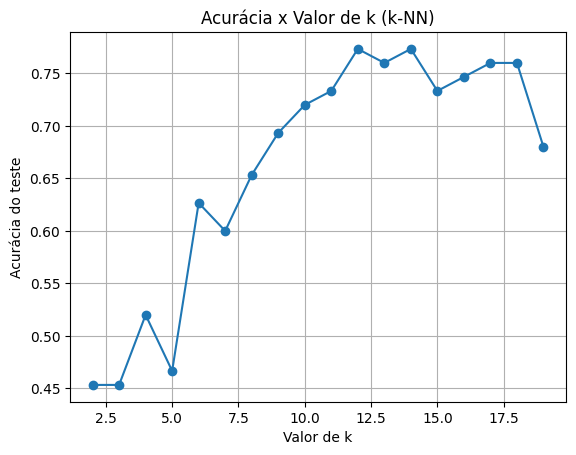

In [240]:
plt.plot(k_values, accuracies, marker="o")
plt.xlabel("Valor de k")
plt.ylabel("Acurácia do teste")
plt.title("Acurácia x Valor de k (k-NN)")
plt.grid(True)
plt.show()

Matriz de Confusao dos testes

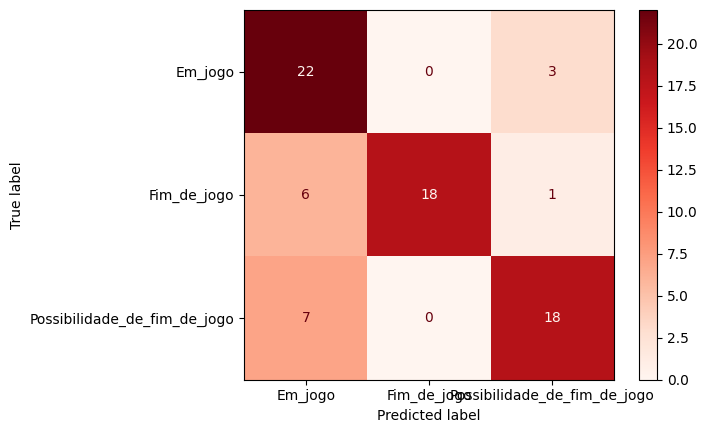

In [241]:
clf = neighbors.KNeighborsClassifier(n_neighbors=melhor_k)
clf.fit(tr_X,tr_y)
y_pred = clf.predict(teste_X)  # usa DataFrame com nomes de features

cm = confusion_matrix(teste_y, y_pred, labels=clf.classes_)  # garante mesma ordem
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Reds')

In [242]:
print(f'Acurácia {accuracy_score(teste_y, y_pred)}')
print(classification_report(teste_y, y_pred))

Acurácia 0.7733333333333333
                              precision    recall  f1-score   support

                     Em_jogo       0.63      0.88      0.73        25
                 Fim_de_jogo       1.00      0.72      0.84        25
Possibilidade_de_fim_de_jogo       0.82      0.72      0.77        25

                    accuracy                           0.77        75
                   macro avg       0.82      0.77      0.78        75
                weighted avg       0.82      0.77      0.78        75

